# 'Unfold' portions of a protein structure via PyMOL by python script (involving Pandas)

This notebook was prompted by a response to [this biostars question 'How can I linearize certain residues within an existing protein structure to create a dumbbell-shaped structure?'](https://www.biostars.org/p/9588134/#9588134). A more streamlined version that doesn't rely on having Pandas and BioPython at all is availabe [here](demo_unfold_segment.ipynb). Here I left in Pandas because the inspiring post had included it.


It assumes you worked through the code on the 'Index' notebook and then the first available notebook in this series already.



------

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them.</li>
        <li>To run a code cell either click the <i class="fa-play fa"></i> icon on the menu bar above, or click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterisk will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

----

### Additional resources:  
- ['PeptideBuilder: A simple Python library to generate model peptides'. Tien, Sydykova, Meyer, and Wilke. 2013. PeerJ](https://pdfs.semanticscholar.org/bb5e/c79882e799644d6c705c219a2675e93ec2f6.pdf)
- [My Post on Proteopedia entitled 'Generate Unfolded Structures'](https://proteopedia.org/wiki/index.php/User:Wayne_Decatur/Generate_Unfolded_Structures)
- [My Post on Proteopedia entitled 'Moving Components or Parts of Structures'](https://proteopedia.org/wiki/index.php/User:Wayne_Decatur/Moving_Components_or_Parts_of_Structures)
- ['Phi and Psi Angles' page at Proteopedia](https://proteopedia.org/wiki/index.php/Phi_and_Psi_Angles)
- [Informative top text in answer to 'What is the precise definition of Ramachandran angles?'](https://chemistry.stackexchange.com/a/116319)
- [The backbone dihedral angles Phi, Psi, omega for proteins Wikipedia entry](https://en.wikipedia.org/wiki/Dihedral_angle#In_stereochemistry)


Potential Caveat about the references at the end: In the figure there presently on the right side of the Wikipedia entry, the omega angle illustrated seems to be the omega for the previous residue, relative the other angles labeled. I suspect the comment below indicated there may reference that:
>"The figure at right illustrates the location of each of these angles (but it does not show correctly the way they are defined)."
For omega, I suggest consulting [here](https://chemistry.stackexchange.com/a/116319) in conjunction with the Wikipedia page text. However, I wish the caveat that Wikipedia has been more specific or actually consistent. However, the text at Wikipedia is lacking in what iteration it is referencing in the text and so at least it is an omega.

### Further resources about PyMOL commands:  
- https://www.biostars.org/p/9512568/#9513247
- https://www.biostars.org/p/9512568/#9513562
- https://www.biostars.org/p/9512568/#9513706


------------


## Preparation

The intial parts to set up to send commands to PyMol are the same and so we'll define those as block of code we can prepend in front of special things to do.

In [1]:
init_block = '''#!/usr/bin/python

import sys, os

# pymol environment
moddir='/opt/pymol-svn/modules'
sys.path.insert(0, moddir)
os.environ['PYMOL_PATH'] = os.path.join(moddir, 'pymol/pymol_path')

import pymol
import pandas as pd
from Bio.PDB import PDBParser, PDBIO
import warnings
warnings.filterwarnings("ignore")
'''

With a block of code defined that we can use within this running notebook, we can now step through each of the basic steps to get a structure and make an image using it with PyMol.  
(Note that this `init_block` contains some exta things not present in the ones in most of the others because I thought it made sense to put the imports needed for later things here as well.)

Biopython has to be installed because the `from Bio.PDB import PDBParser, PDBIO` line above indicates biopython is involved. This line will handle that here because it wasn't present in sessions launched for the demonstration.

In [2]:
%pip install biopython # `from Bio.PDB import PDBParser, PDBIO` line above indicates biopython is involved

Note: you may need to restart the kernel to use updated packages.


## Retrieving a structure

First let's assign the PDB id code to use. Put it between the quotes in the code cell below and then run it.

In [3]:
PDB_id_code = "2db3"

Let's define a command to get a structure. As pdb format. Because I found `cif` format didn't work well with multiple `load` commands. (Alternatively, run `curl -OL https://files.rcsb.org/download/2db3.pdb` in the terminal here or `!curl -OL https://files.rcsb.org/download/2db3.pdb` in a notebook cell.)

In [4]:
cmd2run = f"cmd.fetch('{PDB_id_code}', type='pdb')"

Let's use the `init_block` now to combine it with the command to run and make a script to get a structure file.

In [5]:
script_txt = init_block + cmd2run
%store script_txt >script_f.py

Writing 'script_txt' (str) to file 'script_f.py'.


Let's run that script and get the structure.

In [6]:
!pymol -cq script_f.py

Actually that obtained file won't work easily because it has multiple copies of chain A. Let's just get the biological assembly for PDB 2db3 and use that. (You probably won't need this step for other structures. **And so skip this step.**)

In [7]:
!curl -OL https://files.rcsb.org/download/2db3.pdb1.gz
!gunzip 2db3.pdb1.gz
!mv 2db3.pdb1 2db3.pdb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80928  100 80928    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k


Let's see if that got the structure by running the next cell which shows the contents of that directory.

In [8]:
ls

2db3.pdb                   doc/              LICENSE            README.md
adjusted_pdb_2db3.pdb      environment.yml   notebooks/         script_f.py
apt.txt                    FORtesting.ipynb  postBuild*         script.py
demo_unfold_segment.ipynb  index.ipynb       quick_preview.png


Note that `2db3.pdb` is now among the list of files in the working directory.

## Unfolding a segment of the protien in the structure 2db3 for Biostars answer

Note there was debate about which angles to use in [the exchange surrounding the biostars question 'How can I linearize certain residues within an existing protein structure to create a dumbbell-shaped structure?'](https://www.biostars.org/p/9588134/#9588134) and so you may wish to consult that and adjust the values if you are not achieveing the results you expect with settings used in this step-through.

Let's define the segment and options in the next few cells.    
Set the chain designation containing the region to be targeted to be 'unfolded' by editing the next cell.

In [9]:
chain_id = "A"

Next define the residue range to 'unfold' and then the angles to use as the 'unfolded' state. 

Set the start and end of the region to unfold in the next two cells. 

In [10]:
start_position = 444 # if the numbering in the structure your protein of interest starts at 1, then
# the lowest, WORKABLE position number possible is 2 for `start_position` because of the way the 
# unfolding implementation works, starting here at residue `i` and using atoms in `i-1` to define the 
# dihedral. And so setting start to 1, would give and out of range error when minus one applied.

In [11]:
end_position = 464 # for a similar reason the number for the end position cannot be more than one less 
# then the length of the protein

Quick check in the next cell that the start and end position are suitable while still at the point in the notebook they are being set.

In [12]:
# because the current implementation uses the atoms of the residue in front of the `start_position`,
# make sure there is a residue there in the structure. And because the implementation uses atoms 
# of the residue after the end one, make sure the end one is one below the last residue in the structure.
assert start_position < end_position, "The end position has to be a higher number than the start.\n Adjust above & run this check again."
check_code = '''cmd.load("the_STRUCTURE_PLACEHOLDER.pdb")
secondary_structure_list_by_resnumber = []
cmd.iterate('chain the_CHAIN_ID_PLACEHOLDER and name ca', 'secondary_structure_list_by_resnumber.append((resv,ss))')
residue_numbers = set([x[0] for x in secondary_structure_list_by_resnumber])
lowest_residue_number = secondary_structure_list_by_resnumber[0][0] 
highest_residue_number = secondary_structure_list_by_resnumber[-1][0]
highest_res_number_allowed_for_end = highest_residue_number - 1
if lowest_residue_number < the_START_POSITION_PLACEHOLDER:
    print("The `start_position`, the_START_POSITION_PLACEHOLDER, should work as set")
else:
    print(f"The `start_position`, the_START_POSITION_PLACEHOLDER, is lower than it can be; try the value `{lowest_residue_number + 1}` or above. See comments where you entered it above.")
if the_END_POSITION_PLACEHOLDER <= highest_res_number_allowed_for_end:
    print(f"The end position, the_END_POSITION_PLACEHOLDER, is at least one below the last residue in the chain, {highest_residue_number}, and so it is good.")
else:
    print("The end position, the_END_POSITION_PLACEHOLDER, you set is too high; try the value `{highest_res_number_allowed_for_end}` or below as the setting and re-run this check. See comments where you entered it above.")
assert lowest_residue_number < the_START_POSITION_PLACEHOLDER, f"The start_position has to be equal to at least one higher than the lowest residue number. Try the value `{lowest_residue_number + 1}` or above."
assert the_END_POSITION_PLACEHOLDER <= highest_res_number_allowed_for_end, f"The end_position has to be equal to at least one lower than the highest residue number. Try the value `{highest_res_number_allowed_for_end}` or below."
assert lowest_residue_number < the_START_POSITION_PLACEHOLDER < highest_residue_number, "The start position has to be in the range of the residue numbers."
assert lowest_residue_number < the_END_POSITION_PLACEHOLDER  < highest_residue_number, "The end position has to be in the range of the residue numbers."
print("===============================================================\\n\\nAll appears good with start and end position settings. Onward.")
'''
check_code = check_code.replace("the_STRUCTURE_PLACEHOLDER",PDB_id_code)
check_code = check_code.replace("the_CHAIN_ID_PLACEHOLDER",chain_id)
check_code = check_code.replace("the_START_POSITION_PLACEHOLDER",str(start_position))
check_code = check_code.replace("the_END_POSITION_PLACEHOLDER",str(end_position))
check_positions_script = init_block + check_code
%store check_positions_script >script.py
print("=====================CHECKING COMMENCING=======================")
!pymol -cq script.py

Writing 'check_positions_script' (str) to file 'script.py'.
=====================CHECKING COMMENCING=======================
The `start_position`, 444, should work as set
The end position, 464, is at least one below the last residue in the chain, 621, and so it is good.

All appears good with start and end position settings. Onward.


<div>
<p> <nbsp;></p>
<p> <nbsp;></p>
</div>

Next, set the degree values to apply for the backbone dihedral angles phi, psi, and omega. The settings below (`new_phi_angle = -120`, `new_psi_angle = 140`, and `new_omega_angle = 180`) should linearize; however, you can modify what is applied by altering the values in the next three cells.

In [13]:
new_phi_angle = -120

In [14]:
new_psi_angle = 140

In [15]:
new_omega_angle = 180 #"The planarity of the peptide bond usually restricts ω to be 180°." Plus that agrees with what ['PeptideBuilder: A simple Python library to generate model peptides'. Tien, Sydykova, Meyer, and Wilke. 2013. PeerJ](https://pdfs.semanticscholar.org/bb5e/c79882e799644d6c705c219a2675e93ec2f6.pdf) uses.

Now let's use those sttings to adjust the main script that processes the unfolding and trigger executing it by running the next cell:

In [30]:
text_2_save='''# Specify file paths
input_pdb_file = "the_STRUCTURE_PLACEHOLDER.pdb"
output_pdb_file = "adjusted_pdb_the_STRUCTURE_PLACEHOLDER.pdb"


# Parse the PDB file
parser = PDBParser()
structure = parser.get_structure("protein", input_pdb_file)

# Function to convert three-letter codes to one-letter codes
three_to_one = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLU": "E", "GLN": "Q", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V",
}

def convert_to_one_letter(three_letter_code):
    three_letter_code = three_letter_code
    if three_letter_code in three_to_one:
        return three_to_one[three_letter_code]
    else:
        return None

# Iterate through residues
df = pd.DataFrame(columns=("Residue_ID", "Residue_Name"))
for model in structure:
    for chain in model:
        if chain.id == "the_CHAIN_ID_PLACEHOLDER":
            for i, residue in enumerate(chain):
                residue_id = residue.id[1]
                if residue_id in range(the_START_POSITION_PLACEHOLDER - 1, the_END_POSITION_PLACEHOLDER + 2):
                    # Note that 'the_START_POSITION_PLACEHOLDER minus 1' on the line above is because omega and phi use atoms in the 
                    # previous residue among the four atoms necessary for specifying the dihedral angle.
                    # And the 'plus two' beyond the `the_END_POSITION_PLACEHOLDER` breaks down like so: we need at least a plus one 
                    # because the psi & omega angles use atoms in the residue following the current residue among the four atoms 
                    # necessary for specifying the dihedral angle, and then the extra one comes from the fact that because Python's 
                    # range function stops before the second number in the range call, and we want to be inclusive, ending with 
                    # collecting the information about the position specified by THE ONE AFTER the `the_END_POSITION_PLACEHOLDER`, 
                    # not the end one itself.
                    residue_name = residue.resname
                    df.loc[len(df)] = residue_id, residue_name
# print(df)
cmd.reinitialize()
cmd.load(input_pdb_file)

# Make Tuples of the Region to unfold on the chain
region_to_unfold_tuples = []
region_to_unfold_selection_tuples = []
for index, row in df.iterrows():
    #print(f"{row.iloc[1]}_{row.iloc[0]}", f"resn {row.iloc[1]} and resi {row.iloc[0]} and chain the_CHAIN_ID_PLACEHOLDER")
    region_to_unfold_selection_tuples.append((f"{row.iloc[1]}_{row.iloc[0]}",f"resn {row.iloc[1]} and resi {row.iloc[0]} and chain the_CHAIN_ID_PLACEHOLDER"))
    region_to_unfold_tuples.append((f"{row.iloc[1]}`{row.iloc[0]}",f"resn {row.iloc[1]} and resi {row.iloc[0]} and chain the_CHAIN_ID_PLACEHOLDER"))
# to insure order cannot be changed, convert the collected lists into tuple of tuples
region_to_unfold_tuples = tuple(region_to_unfold_tuples)
region_to_unfold_selection_tuples = tuple(region_to_unfold_selection_tuples)
    

#object_list = cmd.get_object_list()[1:]
resNumLst = df.Residue_ID # No longer needed, I think

sys.stderr.write("Modifying dihedral angles...\\n")
previousResidue, currentResidue, nextResidue = (None for i in range(3))
for i in range(1, len(region_to_unfold_tuples) - 1):
    #Note the minus one for the upper range comes from that want to process through altering the angles for
    # the penultimate residue in region where collected information because the collected information includes 
    # information the one following the final residue to alter because using information about atoms of 
    # that following residue to specify the psi & omega angles, but don't want to alter the residue after the specified one.
    previousResidue = region_to_unfold_tuples[i-1][0]
    currentResidue = region_to_unfold_tuples[i][0]
    nextResidue = region_to_unfold_tuples[i+1][0]

    
    cmd.set_dihedral(f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{previousResidue}/C", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/N", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/CA", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/C", -120, quiet=0) # phi
    cmd.set_dihedral(f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/N", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/CA", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/C", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{nextResidue}/N", 140, quiet=0)# psi
    cmd.set_dihedral(f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/CA", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{currentResidue}/C", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{nextResidue}/N", f"/the_STRUCTURE_PLACEHOLDER//the_CHAIN_ID_PLACEHOLDER/{nextResidue}/CA", 180, quiet=0) # omega
    
'''
cmds2run = '''
sys.stderr.write( "Saving preview image and modified PDB file...\\n")
cmd.set ("ray_opaque_background", 0)
cmd.bg_color ("white")
cmd.set ("cartoon_fancy_helices", 1)
cmd.set ("cartoon_side_chain_helper", "on")
cmd.hide ("everything", "all")
cmd.show ("cartoon", "all")
#pymol.cmd.color ("skyblue", "chain the_CHAIN_ID_PLACEHOLDER")
def hex_to_rgb(value):
    #based on https://stackoverflow.com/a/214657/8508004
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
cmd.set_color ("wld_blue_yonder_color", [*hex_to_rgb("#7D80B0")])
cmd.color ("wld_blue_yonder_color", "chain the_CHAIN_ID_PLACEHOLDER")
#cmd.select ("ALL")
cmd.select ("featured_region", "resi the_START_POSITION_PLACEHOLDER-the_END_POSITION_PLACEHOLDER and chain the_CHAIN_ID_PLACEHOLDER")
cmd.center("featured_region")
cmd.zoom("ALL")
cmd.set ("fog_start", 0.90)
cmd.png("quick_preview.png", 800, 800, dpi=300, ray=1)
cmd.save(output_pdb_file)
'''
text_2_save = text_2_save.replace("the_STRUCTURE_PLACEHOLDER",PDB_id_code)
text_2_save = text_2_save.replace("the_CHAIN_ID_PLACEHOLDER",chain_id)
text_2_save = text_2_save.replace("the_START_POSITION_PLACEHOLDER",str(start_position))
text_2_save = text_2_save.replace("the_END_POSITION_PLACEHOLDER",str(end_position))
text_2_save = text_2_save.replace("the_PHI_PLACEHOLDER",str(new_phi_angle))
text_2_save = text_2_save.replace("the_PSI_PLACEHOLDER",str(new_psi_angle))
text_2_save = text_2_save.replace("the_OMEGA_PLACEHOLDER",str(new_omega_angle))
cmds2run = cmds2run.replace("the_STRUCTURE_PLACEHOLDER",PDB_id_code)
cmds2run = cmds2run.replace("the_CHAIN_ID_PLACEHOLDER",chain_id)
cmds2run = cmds2run.replace("the_START_POSITION_PLACEHOLDER",str(start_position))
cmds2run = cmds2run.replace("the_END_POSITION_PLACEHOLDER",str(end_position))
big_script = init_block + text_2_save + cmds2run
%store big_script >script.py
!pymol -cq script.py
import sys
sys.stderr.write(f"Complete!!!\nLook for resulting `adjusted_pdb_{PDB_id_code}.pdb` and `quick_preview.png`.\n");

Writing 'big_script' (str) to file 'script.py'.
Modifying dihedral angles...
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.000
 SetDihedral: adjusted to -120.000
 SetDihedral: adjusted to 140.000
 SetDihedral: adjusted to 180.

Complete!!!
Look for resulting `adjusted_pdb_2db3.pdb` and `quick_preview.png`.


Run the next cell to preview the resulting strucuture.

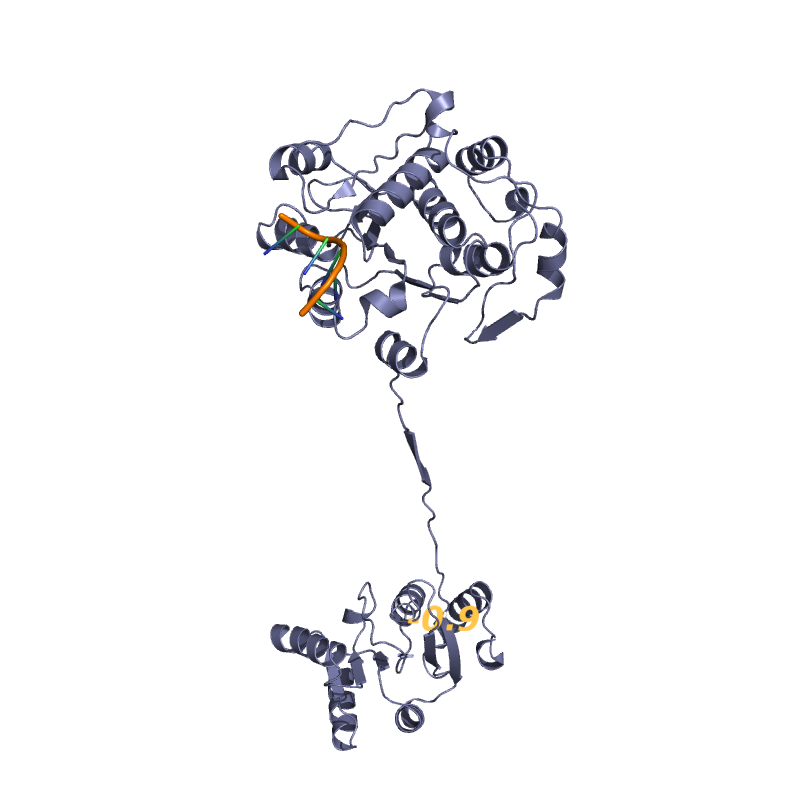

In [31]:
from IPython.display import Image
Image("quick_preview.png")

--------

Enjoy!